In [4]:
# For Data Processing & ML Models
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img
from PIL import Image, ImageEnhance

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Miscellaneous
from tqdm import tqdm
import os
import random

# Turn off warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [7]:
unique_labels = ['Karacadag', 'Basmati', 'Jasmine', 'Arborio', 'Ipsala']

data_dir = '/content/drive/MyDrive/machine learning projects/training set/Rice_Image_Dataset/'

all_paths = []
all_labels = []

for label in unique_labels:
    for image_path in os.listdir(data_dir+label):
        all_paths.append(data_dir+label+'/'+image_path)
        all_labels.append(label)
'''
An image of path all_paths[i] has the label all_labels[i], where i is an index
'''
all_paths, all_labels = shuffle(all_paths, all_labels)
values = [len([x for x in all_labels if x==label]) for label in unique_labels]

In [8]:
x_train_paths, x_val_paths, y_train, y_val = train_test_split(all_paths, all_labels,
                                                              test_size=0.1, random_state=42,
                                                              stratify=all_labels)

In [10]:
BRIGHTNESS = (0.6, 1.4)
CONTRAST   = (0.6, 1.4)

def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(BRIGHTNESS[0],BRIGHTNESS[1]))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(CONTRAST[0],CONTRAST[1]))
    return image

In [12]:
def encode_labels(labels):
    encoded = []
    for x in labels:
        encoded.append(unique_labels.index(x))
    return np.array(encoded)

def decode_labels(labels):
    decoded = []
    for x in labels:
        decoded.append(unique_labels[x])
    return np.array(decoded)
IMAGE_SIZE = 96

In [13]:
def open_images(paths, augment=True):
    '''
    Given a list of paths to images, this function returns the images as arrays, and conditionally augments them
    '''
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE,IMAGE_SIZE))
        if augment:
            image = augment_image(image)
        image = np.array(image)/255.0
        images.append(image)
    return np.array(images)

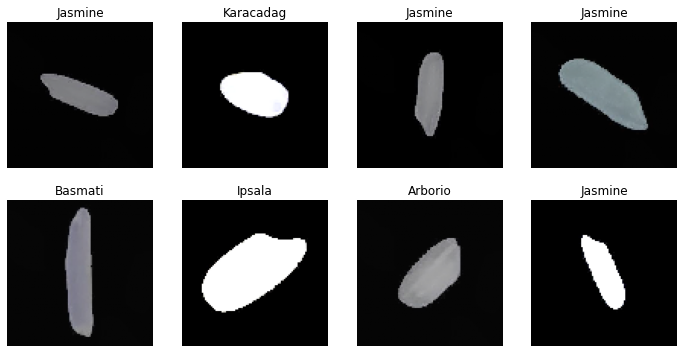

In [14]:
# Load images and their labels
images = open_images(x_train_paths[50:59])
labels = y_train[50:59]

# Plot images with their labels
fig = plt.figure(figsize=(12, 6))
for x in range(1, 9):
    fig.add_subplot(2, 4, x)
    plt.axis('off')
    plt.title(labels[x])
    plt.imshow(images[x])
plt.show()

In [15]:
def datagen(paths, labels, batch_size=12, epochs=3, augment=True):
    for _ in range(epochs):
        for x in range(0, len(paths), batch_size):
            batch_paths = paths[x:x+batch_size]
            batch_images = open_images(batch_paths, augment=augment)
            batch_labels = labels[x:x+batch_size]
            batch_labels = encode_labels(batch_labels)
            yield batch_images, batch_labels

In [ ]:
model = Sequential()
model.add(Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(unique_labels), activation='softmax'))